In [25]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt 
import seaborn as sns

import sys
sys.path.append('../')

from matplotlib import cm
from src.models import autoencoder_model

# reproducibility
np.random.seed(123)
random.seed(123)

DATA_DIR = '../data'

# color palette
colors = sns.color_palette("Set2", n_colors=5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare dataset

### Load data and visualise mode energies

The transition into energy equipartition becomes prominently evident in the trajectory generated with a non-linear coupling parameter of $\beta$=1.8. Specifically, energy equipartition manifests after a few superrecurrence cycles in this trajectory.

The plots below depict the energy distribution across all modes throughout the trajectory timeline. The plot on the right focuses specifically on the initial recurrence.

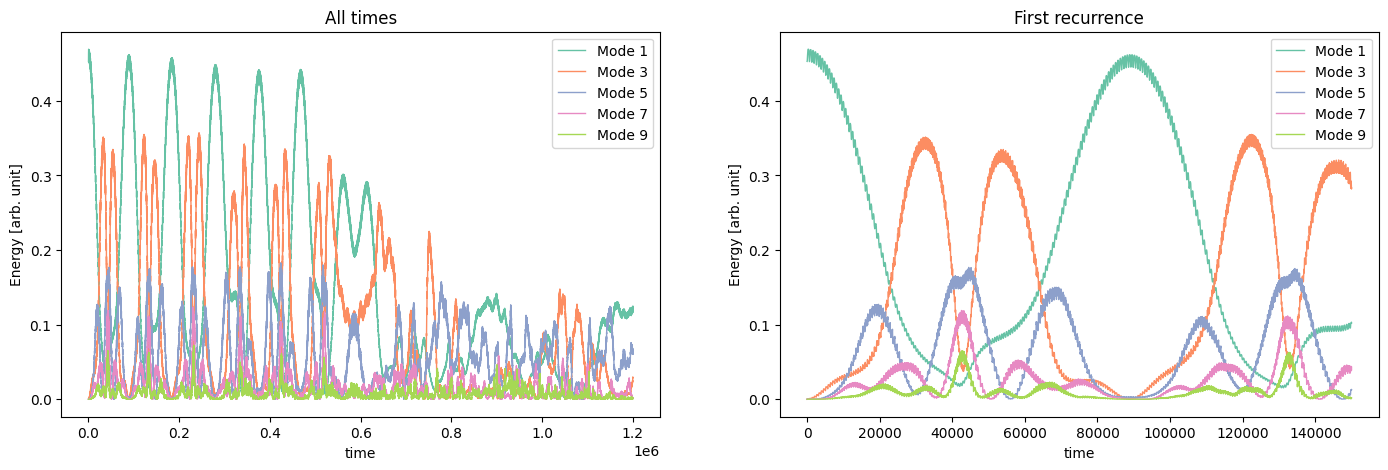

In [2]:
from src.utils import load_data


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))

data = load_data(DATA_DIR, 1.8)
q = data.data_matrix

colors = sns.color_palette("Set2", n_colors=5)

# all times
for i, mode in enumerate([0, 2, 4, 6, 8]):
    ax1.plot(data.energy_matrix[:, mode], linewidth=1, label=f"Mode {mode+1}", color=colors[i]) 

ax1.set_title('All times')
ax1.set_xlabel('time')
ax1.set_ylabel('Energy [arb. unit]')
ax1.legend()

# first recurrence
n_portion = 150000
for i, mode in enumerate([0, 2, 4, 6, 8]):
    ax2.plot(data.energy_matrix[:, mode][:n_portion], linewidth=1, label=f"Mode {mode+1}", color=colors[i]) 

ax2.set_title('First recurrence')
ax2.set_xlabel('time')
ax2.set_ylabel('Energy [arb. unit]')
ax2.legend();

### Dataset Preparation

load trajectory data (considering only the positions "q") from the data matrix, along with the distance from the origin and mode energies over time. A subset of time points containing a recurrence will be extracted from the loaded data, constituting the "train set."

The data is then temporally discretized into intervals of 5 time steps.

In [3]:
from src.utils import temporalize_data


q = data.data_matrix[:, :32] # data.data_matrix contains 32 q, and 32 p
times = data.times
energies = data.energy_matrix
distances = data.dst

q_train = q[:n_portion] 
times_train = times[:n_portion]
energies_train = energies[:n_portion]
distances_train = distances[:n_portion]

timesteps = 5
q_train = temporalize_data(q_train, timesteps)
q = temporalize_data(q, timesteps)

# Compute spectral entropy

The spectral entropy $S$ is used as measure of equipartition. Its rescaled value $\eta$ ranges between 0 and 1 [1], and will be compared to the autoencoded reconstruction error MAE.

In [3] the authors propose to compute the spectral entropy for the high modes only, as the largest contribution to spectral entropy comes from high modes. Hence we also compute the entropy using only high modes (we reref to such quantities as $S_{hm}$, and $\eta_{hm}$, respectively), to be compared with the MAE from the autoencoder.

In [4]:
from src.utils import compute_spectral_entropy

# compute entropy on train set
entropy_train = compute_spectral_entropy(energies_train)
eta_train = (entropy_train - entropy_train.max()) / (entropy_train[0] - entropy_train.max())

entropy_train_hm = compute_spectral_entropy(energies_train, modes=(16, -1))
eta_train_hm = (entropy_train_hm - entropy_train_hm.max()) / (entropy_train_hm[0] - entropy_train_hm.max())

# compute entropy on all trajectory data
entropy = compute_spectral_entropy(energies)
eta = (entropy - entropy.max()) / (entropy[0] - entropy.max())
eta_critic = (1 - 0.577) / (entropy.max() -  entropy[0])  # critical rescaled entropy [1]

entropy_hm = compute_spectral_entropy(energies, modes=(16, -1))
eta_hm = (entropy_hm - entropy_hm.max()) / (entropy_hm[0] - entropy_hm.max())
eta_hm_critic = (1 - 0.577) / (entropy_hm.max() -  entropy_hm[0])  # critical rescaled entropy [1]

#### Visualise spectral entropy / $\eta$ and mode energies

Note: For visualization purposes, I scaled the mode energies by multiplying them by 10 to facilitate better comparison with other quantities.

/var/folders/v1/1r3cbng93gg6xsx3ghwzpk9c0000gn/T/ipykernel_93445/1334603.py:58: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


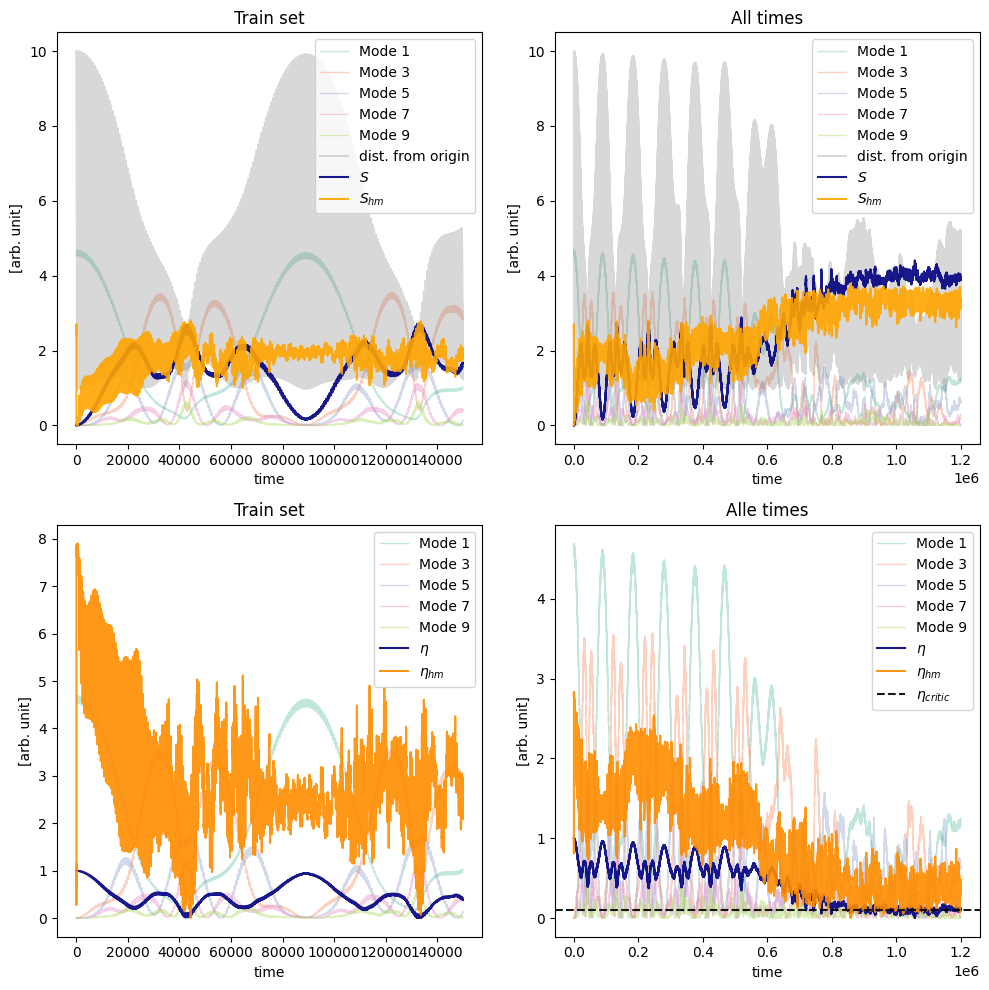

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i, mode in enumerate([0, 2, 4, 6, 8]):
    axs[0].plot(
        times_train, 
        energies_train[:, mode]*10, linewidth=1, 
        label=f"Mode {mode+1}", alpha=0.4, color=colors[i]) 

axs[0].plot(times_train, distances_train , alpha=0.3, label='dist. from origin', color='grey')
axs[0].plot(times_train, entropy_train, alpha=0.9, label='$S$', color='navy')
axs[0].plot(times_train, entropy_train_hm, alpha=0.9, label='$S_{hm}$', color='orange')

axs[0].set_xlabel('time')
axs[0].set_ylabel('[arb. unit]')
axs[0].set_title('Train set')
axs[0].legend()

for i, mode in enumerate([0, 2, 4, 6, 8]):
    axs[1].plot(
        times, 
        energies[:, mode]*10, linewidth=1, 
        label=f"Mode {mode+1}", alpha=0.4, color=colors[i]) 

axs[1].plot(times, distances , alpha=0.3, label='dist. from origin', color='grey')
axs[1].plot(times, entropy, alpha=0.9, label='$S$', color='navy')
axs[1].plot(times, entropy_hm, alpha=0.9, label='$S_{hm}$', color='orange')

axs[1].set_xlabel('time')
axs[1].set_ylabel('[arb. unit]')
axs[1].set_title('All times')
axs[1].legend()

##
for i, mode in enumerate([0, 2, 4, 6, 8]):
    axs[2].plot(times_train, energies_train[:, mode]*10, linewidth=1, label=f"Mode {mode+1}", alpha=0.4, color=colors[i]) 

axs[2].plot(times_train, eta_train, alpha=0.9, label='$\eta$', color='navy')
axs[2].plot(times_train, eta_train_hm, alpha=0.9, label='$\eta_{hm}$', color='darkorange')

axs[2].set_xlabel('time')
axs[2].set_ylabel('[arb. unit]')
axs[2].set_title('Train set')
axs[2].legend()

for i, mode in enumerate([0, 2, 4, 6, 8]):
    axs[3].plot(times, energies[:, mode]*10, linewidth=1, label=f"Mode {mode+1}", alpha=0.4, color=colors[i]) 

axs[3].plot(times, eta, alpha=0.9, label='$\eta$', color='navy')
axs[3].plot(times, eta_hm, alpha=0.9, label='$\eta_{hm}$', color='darkorange')
axs[3].axhline(eta_critic, alpha=0.9, label='$\eta_{critic}$ ', color='black', linestyle='--') #critical rescaled entropy [1]

axs[3].set_xlabel('time')
axs[3].set_ylabel('[arb. unit]')
axs[3].set_title('Alle times')
axs[3].legend()

plt.tight_layout()

Observing the data, it becomes evident that entropy is greater when energy is distributed among higher modes. A larger entropy corresponds to a minimum distance from the origin in the phase space (top pfigures). This suggests that during periods when the system possesses energy in higher modes, trajectories in the phase space tend to revolve around invariant tori of smaller radius.

In the lower right plot, we can obsevre that the system has undergone thermalisation ($\eta$ crosses $\eta_{critic}$) around 0.8 * 10 $^6$.

# Train autoencoder

Train LSTM autoencoder on first portion of trajectory data, where superrecurrence is observed

In [6]:
## uncomment for training. Else load trianed model (cell below)

# model = autoencoder_model(timesteps, n_features=32)
# model.fit(q_train, q_train, epochs=10, batch_size=64, verbose=True)

# model.save("model.h5")

In [7]:
# if model already trained, then load from file

model = tf.keras.models.load_model("model.h5")

### Compute max reconstruction error (MAE) on train set 

Here I calculate the reconstruction error, specifically the mean absolute error between the original input and its autoencoded counterpart. This error will be computed individually for each feature and employed as a threshold. Subsequently, the reconstruction error for future times will be compared to the reconstruction error computed across the entire trajectory data, specifically for times beyond those included in the training set (initial recurrence times).

In [8]:
q_train_pred = model.predict(q_train)

train_mae = np.mean(np.abs(q_train_pred - q_train), axis=1)
feature_thresholds = np.max(train_mae, axis=0)
feature_thresholds.shape

4688/4688 [==============================] - 4s 761us/step


(32,)

### Find phase transition

Here I use the trained autoencoder to perform autoencoding on the full trajectory data. I compute the mean MAE along features (32 degrees of freedom)

In [9]:
q_pred = model.predict(q)

mae_loss = np.mean(np.abs(q_pred - q), axis=1)
mae_avg = mae_loss.mean(axis=1)
mae_avg.shape

37500/37500 [==============================] - 29s 770us/step


(1199994,)

Identify time intervals during which the MAE surpasses the specified threshold. I will visualize these periods on the plots depicting mode energies to discern the modes that exhibit a more significant influence on the thermalization process.

In [11]:
from src.utils import find_time_ranges_above_threshold


merged_ranges = find_time_ranges_above_threshold(mae_loss, feature_thresholds)
print("Times ranges where the MAE is above threshold:", merged_ranges)

Times ranges where the MAE is above threshold: [(231124, 231132), (231169, 231171), (231322, 231331), (231703, 231704), (231805, 231811), (232195, 232196), (319321, 319328), (331283, 331287), (331961, 331966), (332552, 332559), (332722, 332722), (332723, 332723), (333234, 333241), (333391, 333401), (333470, 333474), (333822, 333836), (333846, 333847), (333990, 333999), (334068, 334073), (334623, 334632), (334662, 334671), (334739, 334747), (334893, 334897), (335260, 335263), (421762, 421769), (423717, 423724), (424327, 424335), (425142, 425150), (445751, 445757), (516795, 516803), (517157, 517160), (517396, 517400), (517434, 517436), (517523, 517531), (517944, 517951), (518063, 518080), (518114, 518116), (518433, 518440), (518654, 518662), (518692, 518699), (518802, 518817), (518823, 518832), (519096, 519101), (519178, 519181), (519221, 519231), (519281, 519290), (519339, 519355), (519384, 519392), (519422, 519431), (519466, 519473), (519566, 519572), (519596, 519604), (519883, 519892)

I compute the max of MAE above threshold above features, I refer to this quantity as $MAE_{dev}$. The $MAE_{dev}$ captures how much each MAE value for different features deviates from the corresponding thresholds, and $MAE_{dev}$ represents the maximum deviation across all features.

In [12]:
MAE_deviations = []
for i in range(mae_loss.shape[1]):
    threshold = feature_thresholds[i]
    MAE_deviations.append(mae_loss[:, i] - threshold)

MAE_deviations = np.array(MAE_deviations)
MAE_deviation = np.max(MAE_deviations, axis=0)

#### Compute moving averages

Here I compute the moving average of $MAE_{dev}$, $S$ and $\eta$, to get smoother curves.

In [13]:
window_size = 300 #  The choise of the window size is arbitrary
window = np.ones(window_size) / window_size

MAE_roll_avg = np.convolve(MAE_deviation, window, mode='valid')
entropy_roll_avg = np.convolve(entropy, window, mode='valid')
eta_roll_avg = np.convolve(eta, window, mode='valid')
eta_hm_roll_avg = np.convolve(eta_hm, window, mode='valid')

/Users/alessandro.romualdi/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/alessandro.romualdi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


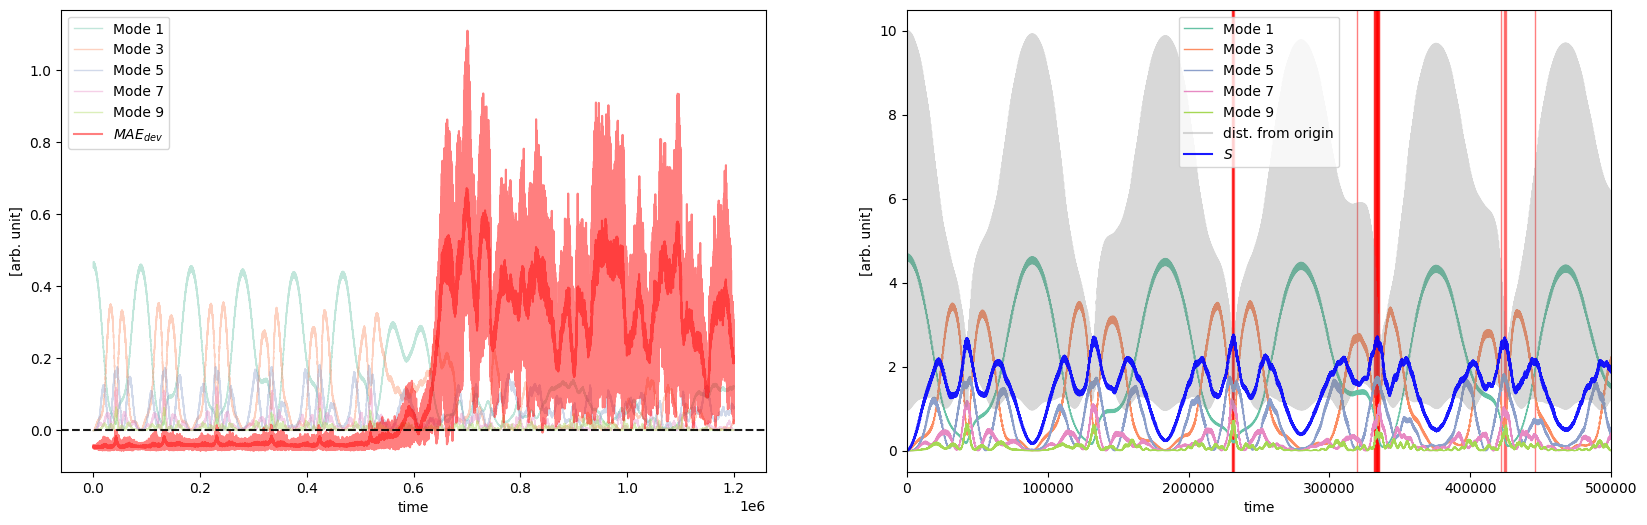

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

for i, mode in enumerate([0, 2, 4, 6, 8]):
    ax1.plot(data.energy_matrix[:, mode], linewidth=1, label=f"Mode {mode+1}", color=colors[i], alpha=0.4)

ax1.plot(MAE_deviation, alpha=0.5, color='red', label="$MAE_{dev}$")
ax1.plot(MAE_roll_avg, alpha=0.5, color='red')
ax1.axhline(0, alpha=0.9, color='black', linestyle='--')
ax1.legend()
ax1.set_xlabel('time')
ax1.set_ylabel('[arb. unit]')

for i, mode in enumerate([0, 2, 4, 6, 8]):
    ax2.plot(data.energy_matrix[:, mode] * 10, linewidth=1, label=f"Mode {mode+1}", color=colors[i])
for r in merged_ranges:
    ax2.axvspan(r[0], r[1], alpha=0.5, color='red')

ax2.plot(times, distances, alpha=0.3, label='dist. from origin', color='grey')    
ax2.plot(times, entropy, alpha=0.9, label='$S$', color='blue')
ax2.set_xlabel('time')
ax2.set_ylabel('[arb. unit]')
ax2.set_xlim(0, 500000)
ax2.legend();

The left plot depicts that the $MAE_{dev}$ recognizes a phase transition marked by the crossing of zero line, and then by a steep, sudden increase in its value. In the right plot, a zoom to times before the equipartition time is provided. In this plot the time corresponding to above-threshold value of $MAE_{dev}$ are annotates as red vertical bands. This way one can visualise one more sub-time inteval within the quasi stationary regime: when the energy coupling starts the route to equipartition. The autoencoder finds such times, which are also times where the spectral entropy shows maxima. We can speculate that the autoencoder is not only able to find the phase transition, but also may find the exact times that correspond to energy exhange anmong high order modes that mark the beginning of the route to thremalisation.

#### Find which oscillator contributes more to autoencoder MAE

I calculate the total duration the $MAE_{dev}$ component of each oscillator is found above the threshold in the identified time ranges. This geves an hint on which oscillator contributes more to the mean absolute error $MAE_{dev}$

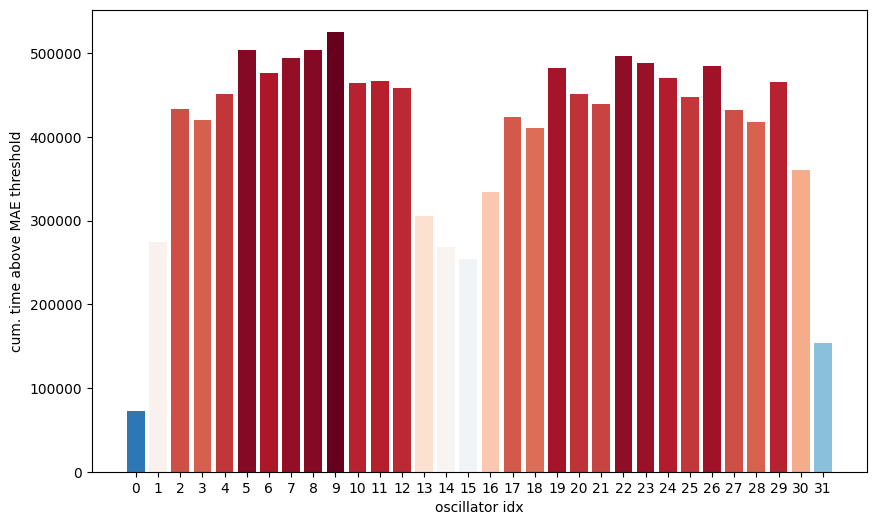

In [15]:
from src.utils import calculate_cumulative_time_above_threshold


cumulative_time_above_threshold = calculate_cumulative_time_above_threshold(mae_loss, feature_thresholds)

# Identify the feature contributing the most
sorted_indices = np.argsort(cumulative_time_above_threshold)[::-1]

plt.figure(figsize=(10, 6))
cmap = cm.get_cmap('RdBu_r')
bars = plt.bar(range(len(cumulative_time_above_threshold)), cumulative_time_above_threshold, color=cmap(cumulative_time_above_threshold / max(cumulative_time_above_threshold)))
plt.xlabel('oscillator idx')
plt.ylabel('cum. time above MAE threshold')
plt.xticks(range(len(cumulative_time_above_threshold)))
plt.show()

The specific behavior of oscillators contributing more to the route to thermalization in FPUT system can depend on various factors, including initial conditions, coupling strengths, and system parameters. 

We observe that oscillators around positions 10 and 20 contribute more significantly to the route to thermalization in your specific FPU system, give the initial condition ...  

## Compare $S$ /$\eta$ with $MAE_{dev}$

### Fit curve to determine phase transition time

To investigate on wether $MAE_{dev}$ has same sensibility of $\eta$ to pahse transition time, I fit a logit function to the curves, to determine time of phase transition time.

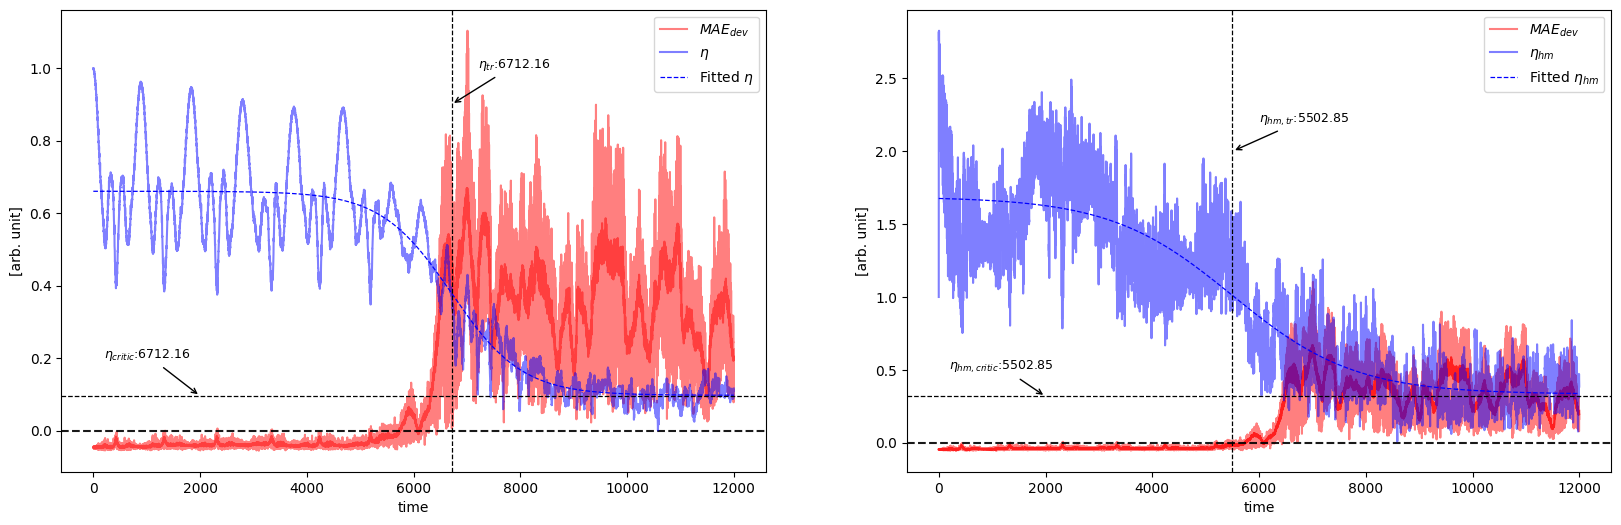

In [24]:
from src.utils import fit_smeared_logistic, smeared_logistic_function


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Downsample for computational efficiency
downsample_factor = 100

# MAE deviation
MAE_roll_avg_ = MAE_roll_avg[::downsample_factor]
MAE_deviation_ = MAE_deviation[::downsample_factor]

ax1.plot(MAE_deviation_, label='$MAE_{dev}$', color='red', alpha=0.5)
ax1.plot(MAE_roll_avg_, color='red', alpha=0.5)
ax1.axhline(0, alpha=0.9, color='black', linestyle='--')

ax2.plot(MAE_deviation_, label='$MAE_{dev}$', color='red', alpha=0.5)
ax2.plot(MAE_roll_avg_, color='red', alpha=0.5)
ax2.plot(MAE_roll_avg_, color='red', alpha=0.5)
ax2.axhline(0, alpha=0.9, color='black', linestyle='--')

# Eta
initial_guess_eta = [6500, 0.3, 0.05, 0.0004]
eta_ = eta[::downsample_factor]
t, params = fit_smeared_logistic(eta_, initial_guess_eta)
eta_phase_tr = params[0]

residuals_eta = eta_ - smeared_logistic_function(t, *params)
chi_squared_eta = np.sum((residuals_eta / eta_)**2)

ax1.plot(t, eta_, label='$\eta$', color='blue', alpha=0.5)
ax1.plot(
    t, smeared_logistic_function(t, *params), 
    label='Fitted $\eta$', linestyle='--', color='blue', linewidth=0.9)
ax1.axvline(params[0], color='black', linestyle='--', linewidth=0.9)
ax1.axhline(eta_critic, color='black', linestyle='--', linewidth=0.9)
ax1.legend()
ax1.set_xlabel('time')
ax1.set_ylabel('[arb. unit]')
ax1.annotate('$\eta_{tr}$:'+f'{params[0]:.2f}',
             xy=(params[0], 0.9), 
             xytext=(params[0]+500, 1.0),  # Adjust the position of the text
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=9)

ax1.annotate('$\eta_{critic}$:'+f'{params[0]:.2f}',
             xy=(2000, eta_critic), 
             xytext=(200, 0.2),  # Adjust the position of the text
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=9)

# Eta High-Modes
downsample_factor_eta_hm = 100
initial_guess_eta_hm = [6500, 0.3, 0.05, 0.04]
eta_hm_ = eta_hm[::downsample_factor_eta_hm]
t, params = fit_smeared_logistic(eta_hm_, initial_guess_eta_hm)
eta_phase_tr = params[0]

ax2.plot(t, eta_hm_, label='$\eta_{hm}$', color='blue', alpha=0.5)
ax2.plot(
    t, smeared_logistic_function(t, *params), label='Fitted $\eta_{hm}$', 
    linestyle='--', color='blue', linewidth=0.9)
ax2.axvline(params[0], color='black', linestyle='--', linewidth=0.9)
ax2.axhline(eta_hm_critic, color='black', linestyle='--', linewidth=0.9)
ax2.set_xlabel('time')
ax2.set_ylabel('[arb. unit]')
ax2.annotate('$\eta_{hm, tr}$:'+f'{params[0]:.2f}',
             xy=(params[0], 2.0), 
             xytext=(params[0]+500, 2.2),  # Adjust the position of the text
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=9)

ax2.annotate('$\eta_{hm, critic}$:'+f'{params[0]:.2f}',
             xy=(2000, eta_hm_critic), 
             xytext=(200, 0.5),  # Adjust the position of the text
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=9)
ax2.legend()

plt.show()

The provided visual representation illustrates the recognition of the same phase transition by both $MAE_{dev}$ and $\eta_{hm}$ metrics. This recognition is evident in the zero-crossing of $MAE_{dev}$ deviation and the observation of half-value logic during the transition. Notably, $\eta_{hm}$ captures a slower transition to equipartition compared to $\eta$, as indicated by the smeared-out fitted logit curve. This delay suggests that higher-order modes initiate the route to thermalization during earlier times. The exclusive consideration of entropy change in high-energy modes by $\eta_{hm}$ plays a significant role in this thermalization process [3].

Furthermore, $\eta$ and $\eta_{hm}$ exhibit large oscillatory behavior during the metastable phase. More specifically, $\eta$ undergoes oscillations synchronized with the transfer of energy across different modes until the exchange of energy reaches equipartition, whereas $\eta_{hm}$ shows longer period oscillation (...). In contrast, the $MAE_{dev}$ distinctly defines a sharp phase transition.

## References

[1] The Metastable State of Fermi–Pasta–Ulam–Tsingou Models <br>
[2] Equipartition threshold in nonlinear large Hamiltonian systems: The Fermi-Pasta-Ulam model <br>
[3] Time–scales to equipartition in the Fermi–Pasta–Ulam problem: finite–size effects and thermodynamic limit G. Benettin and A. Ponno <br>
[4] G. Benettin A. Carati L. Galgani and A. Giorgilli, The Fermi–Pasta–Ulam Problem and the Metastability Perspective <br>
[5] Benettin, G.; Christodoulidi, H.; Ponno, A. The Fermi-Pasta-Ulam Problem and Its Underlying Integrable Dynamics. J. Stat. Phys.
2013, 152, 195–212.  <br>
[6] Benettin, G.; Pasquali, S.; Ponno, A. The Fermi–Pasta–Ulam Problem and Its Underlying Integrable Dynamics: An Approach
Through Lyapunov Exponents. J. Stat. Phys. 2018, 171, 521–542. <br>
[7] K. Ullmann, A. J. Lichtenberg, and G. Corso, Energy equipartition starting from high-frequency modes in the Fermi-Pasta-Ulam b oscillator chain
[8] Danieli, C.; Campbell, D.K.; Flach, S. Intermittent many-body dynamics at equilibrium. Phys. Rev. E 2017, 95, 60202. [CrossRef]
[9]  E. Fermi, J. Pasta, S. Ulam, and M. Tsingtou, in The Many- Body Problem, edited by D. C. Mattis ~World Scientific, Sin- gapore, 1993 reprinted!